# Nonlinear and linear systems and solvers

## Main messages
1. In OpenMDAO terms, your nonlinear system is your model or governing system of equations. Your linear system is a behind-the-scenes linearization of your model used for computing derivatives.
2. You need to use a nonlinear solver when there's backwards coupling or implicit systems; you need to use linear solver when using derivatives for Newton solvers or optimizers.

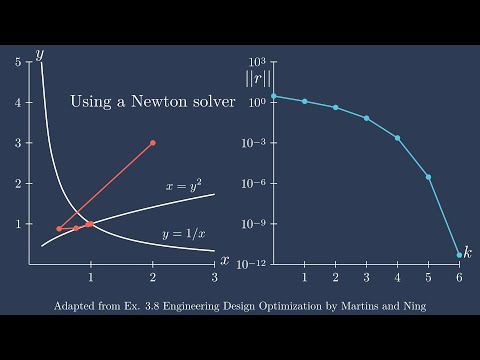

In [1]:
from IPython.display import YouTubeVideo; YouTubeVideo('SwM-LRtiP1c', width=1024, height=576)

## What are nonlinear and linear systems?
I'm going to be painstakingly explicit here in an attempt to clarify an often confusing situation.

When doing MDAO in OpenMDAO, **your model is known as a nonlinear system** regardless of the actual linearity of the model. This means that whatever equations and code lives in your `compute()` statements within OpeNMDAO are all part of the nonlinear system, even if those equations are perfectly linear. This is because OpenMDAO treats the most general case for the system, which include arbitrary nonlinearity.

On the other hand, the **linear system in OpenMDAO is only used to compute gradient information**, and that gradient information is then used for Newton solvers or gradient-based optimization. The portions of code that you write that belong to the linear system are within the `compute_partials()` (for explicit components) and within the `linearize()` (for implicit components) methods. If you're using derivatives within OpenMDAO, you need a linear solver for your linear system.

## Differences between nonlinear and linear solvers
In general, you need both nonlinear and linear solvers for your models. Nonlinear solvers converge any sort of backwards coupling or implicitness in your model. Linear solvers compute the gradients for a linearized approximation of your model.

It's sometimes easy to forget that you need a linear solver since you can often converge your *analysis* using just a nonlinear solver. But without a linear solver, your gradient information will be wrong, leading to poor convergence for your Newton solver or optimization. Heck, when putting together this notebook I forgot to put a linear solver and wondered why my system wasn't converging (whoops).

Check out [[Types of solvers and when to use them]] for an overview of solver types and when to use them. This portion of the lecture really just compares nonlinear and linear solvers and discusses the differences in the mathematics that causes the need for different solver classifications.

## Examples
This first example shows the same two-equation system presented in the lecture. We then solve it using OpenMDAO's nonlinear Newton solver and its linear direct solver. Try playing around with the solver settings, options, and which solvers to use, to see how those changes impact convergence. 

In [1]:
import openmdao.api as om
import numpy as np


prob = om.Problem()

prob.model.add_subsystem('ex1', om.ExecComp('y = 1/x'), promotes=['*'])
prob.model.add_subsystem('ex2', om.ExecComp('x = y**2', x={'lower': 0.5}), promotes=['*'])

# Try it!
# Swap out the Newton solver for a NLBGS solver.
# What behavior do you see? Which solver performs better?
# Can you change any solver options or properties to enhance convergence?
prob.model.nonlinear_solver = om.NewtonSolver(solve_subsystems=False)
# prob.model.nonlinear_solver = om.NonlinearBlockGS()

# Try it!
# If you use no linear solver, what happens? Any change in convergence?
# If you use a different linear solver (like that commented out one), what happens?
prob.model.linear_solver = om.DirectSolver()
# prob.model.linear_solver = om.ScipyKrylov()

prob.setup()
prob.model.nonlinear_solver.options['iprint'] = 2

prob.set_val('x', 2)
prob.set_val('y', 3)

prob.run_model()

NL: Newton 0 ; 7.43303437 1
NL: Newton 1 ; 1.3806158 0.185740538
NL: Newton 2 ; 0.386391403 0.0519829969
NL: Newton 3 ; 0.0664946284 0.0089458255
NL: Newton 4 ; 0.00196427089 0.000264262318
NL: Newton 5 ; 2.0322986e-06 2.73414396e-07
NL: Newton 6 ; 2.06428508e-12 2.77717683e-13
NL: Newton Converged


Okay, next up we have a sort of weird example, but I want to highlight it. We have an extremely trivial model here that consists of two equations and two unknowns. In this case, the equations are **both exactly linear**. Despite this, we still need to set a **nonlinear solver** in OpenMDAO terms. This is because OpenMDAO thinks of your model in the most general sense, which means treating it as a nonlinear system.

However, when using a nonlinear solver like a Newton solver on a linear system, it converges the system in one iteration. This is because when gradients of the linear system make the Newton step exactly accurate throughout the entire design space because they do not change.

This can be confusing because you can easily construct a relevant engineering model that is entirely linear, but you still need to set a nonlinear solver in OpenMDAO. The **linear solver** in OpenMDAO is used only to compute gradients for the model.

In [2]:
prob = om.Problem()

prob.model.add_subsystem('ex1', om.ExecComp('y = 0.5*x + 1.5'), promotes=['*'])
prob.model.add_subsystem('ex2', om.ExecComp('x = (4 - y ) / 0.75'), promotes=['*'])

prob.model.nonlinear_solver = om.NewtonSolver(solve_subsystems=False)
# prob.model.nonlinear_solver = om.NonlinearBlockGS()
prob.model.linear_solver = om.DirectSolver()

prob.setup()
prob.model.nonlinear_solver.options['iprint'] = 2

prob.set_val('x', 1)
prob.set_val('y', 4)

prob.run_model()

NL: Newton 0 ; 2.23606798 1
NL: Newton 1 ; 0 0
NL: Newton Converged
